# 🔎 Retrieval (and QG?) playground

In [102]:
import json, random
import matplotlib.pyplot as plt
from langchain_core.example_selectors import (
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
)
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.retrievers import KNNRetriever
from IPython.display import display, Markdown, Latex
from sentence_transformers import CrossEncoder


## ⚙️ 0. Choose claim & docstore

In [103]:
random.seed(111)

In [104]:
random.randint(0, 500)


423

In [105]:
CLAIM_ID = 252
datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
claim = datapoint["claim"]
docstore = []
for line in open(f"data_store/output_dev/{CLAIM_ID}.json"):
    docstore.append(json.loads(line))
    
# print claim in markdown with some sample evidence
display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] +"]"))
# sample 3
for i in random.sample(range(len(docstore)), 3):
    newline = "\n"
    display(Markdown(f"**{docstore[i]['url']}**\n\n * {newline.join(docstore[i]['url2text'][:10])}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China. [Refuted]

**https://www.nytimes.com/2019/11/26/arts/music/judy-collins.html**

 * 

**https://azsos.gov/elections/campaign-finance/financial-disclosure-statements/2022-financial-disclosure-statements**

 * 

**https://www.wsj.com/articles/employees-ask-facebook-to-reverse-policy-on-political-ad-fact-checking-11572311436**

 * 

### 🗂️ 0.1 Docstore formatting/scraping

In [106]:
# Naive version with \n concatenated url2texts:
documents = [
    Document(
        page_content="\n".join(doc["url2text"]), 
        metadata={
            "url": doc["url"],
            "sentences": doc["url2text"]
        }
    )
    for doc in docstore
]
documents[random.randint(0, len(documents))]

Document(page_content='Industry Update for Small Scale Residential Construction (28/09/2020)\nHappy Monday. I hope you are having a great start to the week! I’ve been compiling this information to give you a succinct explanation of the current updates as I know there is a lot of confusion and overwhelm and it would be great to have things clearly laid out.\nOn Sunday, our Premier Dan Andrews downgraded our industry’s status from the first step / ‘heavily restricted’ to the second step / ‘restricted’ stage of the COVID road map in Metropolitan Melbourne (Click here for info).\nAn important change to note is that it is now mandatory to wear a fitted face mask that fully covers your nose and mouth.\nWe have been given two weeks’ grace before penalties will be imposed for wearing the wrong type of face mask, so please make sure that all workers are wearing the appropriate face masks when leaving home to avoid any unnecessary fines.\nEnforcement of the updated face covering requirements wil

### 📊 Docstore hist & truncation

(array([238.,  50.,  32.,  27.,  24.,  32.,  23.,  28.,  18.,  19.,  23.,
         16.,  21.,  17.,   9.,   4.,   8.,  10.,   8.,   4.,   6.,   5.,
          4.,   7.,   3.,   5.,   3.,   4.,   7.,   3.,   2.,   1.,   5.,
          0.,   3.,   4.,   4.,   4.,   3.,   5.,   2.,   0.,   2.,   2.,
          2.,   2.,   1.,   1.,   2.,   5.]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
         33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,
         66.,  69.,  72.,  75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,
         99., 102., 105., 108., 111., 114., 117., 120., 123., 126., 129.,
        132., 135., 138., 141., 144., 147., 150.]),
 <BarContainer object of 50 artists>)

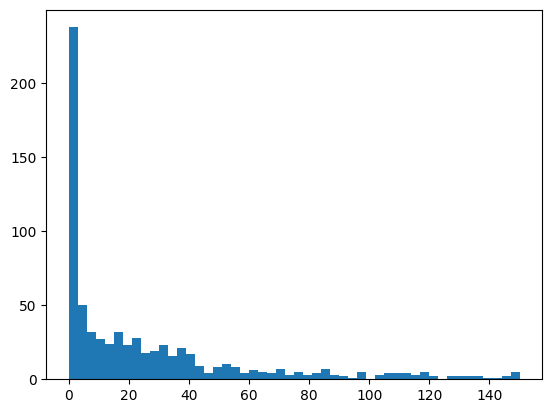

In [107]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.metadata["sentences"]) for doc in documents], bins=50, range=(0, 150))

In [108]:
# show doc with most sentences
max_sentences = max(documents, key=lambda d: len(d.metadata["sentences"]))
max_sentences.metadata["url"]
max_sentences.page_content[:1000]

"Full text is available to Purdue University faculty, staff, and students on campus through this site.\nOff-campus Purdue users may download theses and dissertations by logging into the Libraries' proxy server with your Purdue Career Account.\nLinks to log in to the proxy server directly below the download button of each thesis or dissertation page.\nNon-Purdue users, may purchase copies of theses and dissertations from ProQuest or talk to your librarian about borrowing a copy through Interlibrary Loan.\n(Some titles may also be available free of charge in our Open Access Theses and Dissertations Series, so please check there first.)\nFortney, Sarah Katherine (2024) The Role of Trait and Specific Expectations in the Experience of Dysmenorrhea\nAbdullah, Umm E. Hani (2023) Exploratory Study of Deep Brain Stimulation in the Syngap1+/- Mouse Model of Autism Spectrum Disorder Using Electrophysiology\nAbney, Douglas John (2023) Broadband’s Role in Agricultural Job Postings In U.S. Counties\

(array([254.,  38.,  24.,  27.,  19.,  28.,  29.,  23.,  18.,  14.,  14.,
         13.,  35.,  13.,  12.,  15.,   9.,  10.,   9.,   8.,   7.,   5.,
          4.,   4.,   2.,   3.,   7.,   2.,   1.,   5.,   3.,   3.,   8.,
          5.,   3.,   4.,   1.,   1.,   4.,   1.,   0.,   2.,   4.,   4.,
          0.,   3.,   2.,   1.,   3.,   3.]),
 array([    0.,   400.,   800.,  1200.,  1600.,  2000.,  2400.,  2800.,
         3200.,  3600.,  4000.,  4400.,  4800.,  5200.,  5600.,  6000.,
         6400.,  6800.,  7200.,  7600.,  8000.,  8400.,  8800.,  9200.,
         9600., 10000., 10400., 10800., 11200., 11600., 12000., 12400.,
        12800., 13200., 13600., 14000., 14400., 14800., 15200., 15600.,
        16000., 16400., 16800., 17200., 17600., 18000., 18400., 18800.,
        19200., 19600., 20000.]),
 <BarContainer object of 50 artists>)

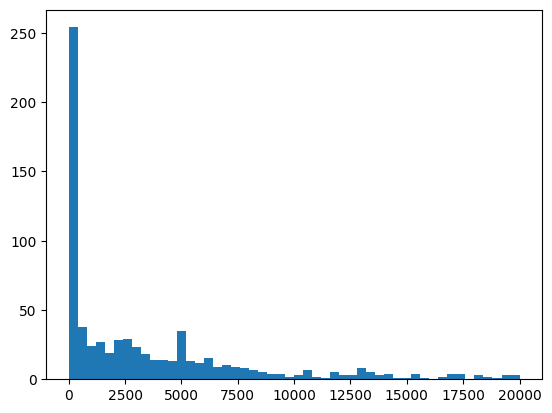

In [109]:
plt.hist([len(doc.page_content) for doc in documents], bins=50, range=(0, 20000))

In [110]:
# trim document page contents to 13000 characters
for doc in documents:
    doc.page_content = doc.page_content[:13000]

## 📐 1. Embedding searches

In [111]:
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [112]:
reranker = KNNRetriever.from_documents(documents, embeddings, k=10)
results = reranker.get_relevant_documents(claim)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1*



**https://www.nzherald.co.nz/nz/judith-collins-accused-of-potential-conflict-of-interest/NXKZLIY4IZNGIN6GKTNQZQSJWQ/**

Justice Minister Judith Collins has been accused of potentially breaching conflict of interest rules for Cabinet ministers after a visit to a company her husband is a director of while in China.
One News reported that while Ms Collins was in China last Oct

**https://www.nzherald.co.nz/nz/collins-told-oravida-its-milk-was-nice/4NLEWGILMPCQRYPT5XAA5IMN2I/**

Justice Minister Judith Collins said she told milk product company Oravida that it could not use her photograph or name to endorse its products prior to visiting it in China last year and although its milk was "nice" that was not an endorsement of the comp

**https://eitr545824759.wordpress.com/2020/08/08/judith-collins-david-wong-tung-and-the-oravida-kauri-ltd-ruakaka-connection-and-that-broken-marsden-point-fuel-line-breakage-that-caused-nz-48m-in-economic-damage-no-one-has-subsequently-been-charged/**

David Wong-Tung, the husband of then energy minister Judith Collins, was a director of Kauri Ruakaka until 2017, but is no longer on its board.
Former Engineering NZ president Elena Trout who headed the inquiry, said it understood the contractor sold swamp

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars.
Oravida pays about $500 a year to draw up

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri.
The above quote was when Judith was challenged that Oravida was damaging the environment.
What a sad day for Judith, appar

**https://www.newshub.co.nz/home/money/2016/04/oravida-jumps-in-to-export-kiwi-water.html**

New Zealand water could be the next big export to China and one of the companies that has just jumped in for a slice of the pie is none other than Oravida.
The company is only paying a small amount to the council for the millions of litres it can take.
Sto

**https://thedailyblog.co.nz/2014/03/05/crusher-collins-conflict-of-interest-seems-as-large-as-her-interest-in-conflict/**

Collins says Oravida visit not conflict of interest
Judith Collins went on a taxpayer-funded visit to China last year. In her public role as Justice Minister, she was there to talk about our system.
But she was also welcomed into a New Zealand export compa

**https://www.newshub.co.nz/home/new-zealand/2015/10/greens-mp-apologises-over-swamp-kauri-claim.html**

A Green MP has apologised to Judith Collins' husband following a press release condemning the extraction of valuable swamp kauri.
In a statement released by the party's conservation spokeswoman Eugenie Sage in June, she called for the illegal export of anc

**https://www.odt.co.nz/business/nz-milk-fetches-big-bucks-china**

You are not permitted to download, save or email this image. Visit image gallery to purchase the image.
But the high-price reflects a more complicated supply chain - and the degree to which the high-quality product is sought after in China.
It's just one o

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.”
So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

## 📐 Max. Marginal relevance


In [113]:
Chroma().delete_collection()
documents_ = [doc.copy() for doc in documents]
for doc in documents_:
    doc.metadata.pop("sentences", None)
    
chroma = Chroma.from_documents(documents_, embeddings)


In [118]:
results = chroma.max_marginal_relevance_search(claim, 10, 100, .5)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + " (mmr λ=0.5)*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-embed-large-v1 (mmr λ=0.5)*



**https://www.nzherald.co.nz/nz/judith-collins-accused-of-potential-conflict-of-interest/NXKZLIY4IZNGIN6GKTNQZQSJWQ/**

Justice Minister Judith Collins has been accused of potentially breaching conflict of interest rules for Cabinet ministers after a visit to a company her husband is a director of while in China.
One News reported that while Ms Collins was in China last Oct

**https://thedailyblog.co.nz/2018/11/11/a-sad-day-for-judith-collins/**

When Judith wasn’t questionably meeting Chinese border officials or diverting to its trade events, Oravida also exported swamp Kauri.
The above quote was when Judith was challenged that Oravida was damaging the environment.
What a sad day for Judith, appar

**https://www.rnz.co.nz/news/national/301943/'we're-giving-away-that-water-for-nothing'**

Oravida is exporting millions of litres of New Zealand water to China, and the Green Party says it is wrong that they are paying practically nothing for it, while potentially making hundreds of millions of dollars.
Oravida pays about $500 a year to draw up

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.”
So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://newsroom.co.nz/2020/08/10/wong-tung-threatens-to-sue-newsroom/**

National leader Judith Collins’ husband is threatening defamation action against Newsroom over a story about a West Coast mine site that the conservation department allowed to be left in a state likened to a “moonscape” by a conservationist.
David Wong-Tun

**https://www.rnz.co.nz/news/political/423287/national-caucus-to-vote-against-cannabis-at-referendum-judith-collins**

National leader Judith Collins says the entire National Party caucus had decided to vote against the Cannabis Legalisation and Control Bill in the referendum.
The referendum asks voters if they support the proposed Cannabis Legalisation and Control Bill, w

**https://en.wikipedia.org/wiki/Leader_of_the_Opposition_(New_Zealand)**

|While leader of the largest political party in the House of Representatives that is not in government
|^ a. As the first parliamentary leader of an Opposition party.
^ b. The date Ballance was officially named Leader of the Opposition.
In New Zealand, the

**http://www.atelieraitken.org/new-blog/new-zealand-concept-store-opens-in-shanghai**

New Zealand food company Oravida opened China’s first flagship store in Shanghai on Nov 1, 2014. Rt Hon Dame Jenny Shipley, the former Prime Minister of New Zealand, opened the building, which sells New Zealand produce.
http://english.eastday.com/auto/east

**https://www.theguardian.com/world/2019/may/08/new-zealand-introduces-bill-for-zero-carbon-emissions-by-2050**

A landmark bill which would set a target of zero carbon emissions for New Zealand by 2050 has been tabled in the New Zealand parliament.
Prime minister Jacinda Ardern said on Wednesday that the bill, which would introduce targets for carbon and biogenic me

**https://www.ifama.org/resources/documents/v19ib/14_shadbolt.pdf**

 2016 International Food and Agribusiness Management Association (IFAMA). All rights reserved. 241
International Food and Agribusiness Management Review 
Factors Influencing the Dairy Trade from New Zealand 
a Professor, Farm & Agribusiness Management, Co

## ❌ Cross-encoder re-ranking 

In [115]:
# Load the model, here we use our base sized model
model_name = "mixedbread-ai/mxbai-rerank-large-v1"
model = CrossEncoder(model_name)

# Example query and document

# Lets get the scores
results = model.rank(claim, [doc.page_content for doc in documents], return_documents=True, top_k=10)


display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    r = documents[r['corpus_id']]
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

### 🗯️ New Zealand opposition leader Judith Collins is opposed to new environmental legislation because of her connection to Oravida, a local water and dairy company that exports produce to China.

*Retrieved by mixedbread-ai/mxbai-rerank-large-v1*



**https://www.sbs.com.au/news/article/new-zealand-opposition-chooses-judith-collins-to-take-on-jacinda-ardern-at-september-election/pd95nod40**

Long-serving politician Judith Collins will lead New Zealand's opposition National Party into an election against a popular government in just over two months, taking over from Todd Muller, who quit as leader citing health reasons.
Mr Muller shocked politi

**https://www.theguardian.com/world/2020/jul/18/we-have-a-fighting-chance-judith-collins-backs-herself-against-ardern-in-new-zealand-election**

“I am very straightforward, people who are threatened by that will be threatened by me.”
So says Judith Collins, the new leader of New Zealand’s main opposition party, and the woman who faces the task of unseating one of the country’s most popular prime mi

**https://www.theguardian.com/world/2020/jul/14/judith-collins-named-new-zealand-national-party-new-leader**

New Zealand’s prime minister, Jacinda Ardern, widely known for her exhortations to kindness and compassion, will face Judith Collins – a combative, tough-talking conservative lawmaker who styled herself after Margaret Thatcher – in the country’s general el

**https://thedailyblog.co.nz/2020/07/16/the-judith-collins-led-national-party-be-scared-be-very-scared/**

WHOEVER E-MAILED MARK RICHARDSON on Wednesday morning’s AM Show was right: Judith Collins scares me. For the first time since National’s caucus replaced Don Brash with John Key, the party has chosen a leader who can win.
The new Leader of the Opposition is

**https://www.interest.co.nz/news/106045/national-caucus-elects-judith-collins-partys-new-leader-deputy-unknown-press-conference**

Judith Collins has been elected National Party Leader, following Todd Muller’s shock resignation from the role on Tuesday morning.
The National Party caucus took about two hours to make the decision on Tuesday evening. Thereafter, members of the caucus sto

**https://thedailyblog.co.nz/2020/07/23/guest-blog-bryan-bruce-collins-and-muldoon/**

I’ve seen a couple of recent political commentaries comparing National’s new leader Judith Collins to the late former Prime Minister Robert Muldoon who dominated New Zealand politics from the mid 1970’s to the mid 1980’s.
Certainly the little bit of the fi

**https://www.rnz.co.nz/news/political/421417/national-leader-judith-collins-announces-infrastructure-plan-rma-repeal**

An eye-watering $31 billion is the price tag National has put on the infrastructure upgrade required to fix the country's transport network and Auckland and upper North Island's congestion crisis.
In her first big policy announcement today, new National le

**https://newzeelend.wordpress.com/2019/06/25/judith-collins-guardian-angel-or-gatekeeper-from-hell/**

Judith Collins: Guardian Angel, or Gatekeeper from Hell?
Sent by a reader in Sewage City [aka, “Wellington”]
Judith Anne Collins (born 24 February 1959) is the National MP for Papakura and was a government minister under John Key and Bill English.
“Collins

**https://www.newshub.co.nz/home/politics/2020/07/judith-collins-biggest-controversies-troublesome-tweets-resignations-and-dirty-politics.html**

Judith Collins is the new leader of National after the party accepted Todd Muller's resignation and backed her to take over on Tuesday.
It's been a tumultuous road to the helm for Collins, a role she's put herself forward for twice before - one fraught wit

**https://bryangould.com/2018/10/**

The fall-out from the Jami-Lee Ross debacle no doubt accounts for Simon Bridges’ latest poll rating as preferred Prime Minister, at just 7%.
Political commentators have interpreted this as the writing on the wall and have become excited at the prospect of 